# Algorithm Training and Testing

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample

In [2]:
# Initialize variables
random_state = 6
test_size = 0.2
db_file = 'your_databse.csv'
split_date = '2020-01-01'

In [3]:
# Load data into data frame
df = pd.read_csv(db_file,
                 encoding="utf-8",
                 sep=";",
                 header=0
                )

In [4]:
# Include only most recent tumor boards to reflect current tumorboard guidelines
df['pretb_date'] = pd.to_datetime(df['pretb_date'], dayfirst=True)
df = df.loc[df['pretb_date'] > split_date]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1929 entries, 5050 to 6978
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   pid             1929 non-null   object        
 1   pretb_date      1929 non-null   datetime64[ns]
 2   birth_date      1929 non-null   object        
 3   age             1929 non-null   int64         
 4   psa             1854 non-null   float64       
 5   dre             1922 non-null   object        
 6   gleason_1       1919 non-null   float64       
 7   gleason_2       1919 non-null   float64       
 8   gleason_sum     1919 non-null   float64       
 9   isup            1919 non-null   float64       
 10  cylinder_total  1837 non-null   float64       
 11  cylinder_pos    1836 non-null   float64       
 12  site            1732 non-null   object        
 13  pretb_text      1929 non-null   object        
 14  bs              1929 non-null   bool          
 15  ct    

In [6]:
ord_enc = OrdinalEncoder()

In [7]:
# Convert categorical variables from text to numerical
df['dre'] = ord_enc.fit_transform(df[['dre']])
df['site'] = ord_enc.fit_transform(df[['site']])

In [8]:
# Define features and outcomes
feature_cols = ['age', "psa", "dre", 'site', "isup", "cylinder_pos", "cylinder_total", 'ht', 'dm', 'cad', 'bmi', 'preop']
outcome_cols = ["psma", 'conv_staging', "as", 'rp_rt']
X = df[feature_cols]
y = df[outcome_cols]

In [9]:
# Stratification of train test split according to outcomes with lowest numbers
y_strat = y.loc[:, ['psma', 'as']]

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y_strat, random_state=random_state)

In [11]:
# Impute missing values for continuous variables using median of training set
imp1 = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit and transform on training set
X_train['psa'] = imp1.fit_transform(X_train[['psa']])
X_train['cylinder_pos'] = imp1.fit_transform(X_train[['cylinder_pos']])
X_train['cylinder_total'] = imp1.fit_transform(X_train[['cylinder_total']])

# Transform on test set
X_test['psa'] = imp1.fit_transform(X_test[['psa']])
X_test['cylinder_pos'] = imp1.fit_transform(X_test[['cylinder_pos']])
X_test['cylinder_total'] = imp1.fit_transform(X_test[['cylinder_total']])

In [12]:
# Impute missing values for categorial variables using most frequent in training set
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# Fit and transform on training set
X_train['isup'] = imp2.fit_transform(X_train[['isup']])
X_train['site'] = imp2.fit_transform(X_train[['site']])
X_train['dre'] = imp2.fit_transform(X_train[['dre']])

# Transform on test set
X_test['isup'] = imp2.fit_transform(X_test[['isup']])
X_test['site'] = imp2.fit_transform(X_test[['site']])
X_test['dre'] = imp2.fit_transform(X_test[['dre']])

In [13]:
# Train DecisionTree model
dt_clf = DecisionTreeClassifier(max_leaf_nodes=50, criterion="entropy", random_state=random_state)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

In [14]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[314,  14],
        [ 47,  11]],

       [[282,  13],
        [ 64,  27]],

       [[351,  12],
        [  3,  20]],

       [[  0,   2],
        [  2, 382]]], dtype=int64)

In [15]:
print ("Accuracy : ", accuracy_score(y_test, y_pred))

Accuracy :  0.6839378238341969


In [16]:
print(classification_report(y_test, y_pred, target_names=outcome_cols))

              precision    recall  f1-score   support

        psma       0.44      0.19      0.27        58
conv_staging       0.68      0.30      0.41        91
          as       0.62      0.87      0.73        23
       rp_rt       0.99      0.99      0.99       384

   micro avg       0.91      0.79      0.85       556
   macro avg       0.68      0.59      0.60       556
weighted avg       0.87      0.79      0.81       556
 samples avg       0.95      0.87      0.88       556



c:\Users\sheri\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# Train RandomForest model
rnd_clf = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=random_state)

rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)

In [18]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[308,  20],
        [ 40,  18]],

       [[283,  12],
        [ 58,  33]],

       [[357,   6],
        [  5,  18]],

       [[  0,   2],
        [  0, 384]]], dtype=int64)

In [19]:
print ("Accuracy : ", accuracy_score(y_test, y_pred))

Accuracy :  0.6994818652849741


In [20]:
print(classification_report(y_test, y_pred, target_names=outcome_cols))

              precision    recall  f1-score   support

        psma       0.47      0.31      0.38        58
conv_staging       0.73      0.36      0.49        91
          as       0.75      0.78      0.77        23
       rp_rt       0.99      1.00      1.00       384

   micro avg       0.92      0.81      0.86       556
   macro avg       0.74      0.61      0.66       556
weighted avg       0.89      0.81      0.84       556
 samples avg       0.95      0.88      0.89       556



c:\Users\sheri\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# Train KNN model
knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)

In [22]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[317,  11],
        [ 47,  11]],

       [[273,  22],
        [ 56,  35]],

       [[363,   0],
        [ 20,   3]],

       [[  0,   2],
        [  0, 384]]], dtype=int64)

In [23]:
print ("Accuracy : ", accuracy_score(y_test, y_pred))

Accuracy :  0.6658031088082902


In [24]:
print(classification_report(y_test, y_pred, target_names=outcome_cols))

              precision    recall  f1-score   support

        psma       0.50      0.19      0.28        58
conv_staging       0.61      0.38      0.47        91
          as       1.00      0.13      0.23        23
       rp_rt       0.99      1.00      1.00       384

   micro avg       0.93      0.78      0.85       556
   macro avg       0.78      0.43      0.49       556
weighted avg       0.88      0.78      0.80       556
 samples avg       0.96      0.85      0.88       556



c:\Users\sheri\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# Create test sample for model out evaluation
test_sample = X_test.iloc[13, :].to_frame().transpose()
test_output = rnd_clf.predict(test_sample)

In [26]:
def convert_output(output):
    psma_string = "Bevorzugt PSMA-PET-CT. Alternativ Ganzkörperknochenszintigraphie und CT-Abdomen und Becken. "
    ct_scintigraphy_string = "Ganzkörperknochenszintigraphie und CT-Abdomen und Becken."
    as_string = "Der Patient erfüllt die Kriterien für eine aktive Überwachung. Falls eine definitive Therapie erwünscht ist, Angebot einer radikalen Prostatektomie oder alternativ perkutane Strahlentherapie."
    rp_rt_string = "Indikation zur radikalen Prostatektomie. Alternativ perkutane Strahlentherapie."
    
    output_string = ""
    
    if output[0] == 1:
        # PSMA
        output_string += psma_string

    if output[1] == 1:
        # CT and bone scintigraphy
        if output[0] == 0:
            output_string += ct_scintigraphy_string
            
    if output[2] == 1:
        # Active Surveillance
        output_string += as_string

    if output[3] == 1:
        # Radical prostatectomy and radiation therapy
        if output[2] == 0:
            output_string += rp_rt_string
    
    return output_string

In [27]:
test_output = test_output[0]
output_string = convert_output(test_output)

In [28]:
print(test_output)
print(output_string)

[False False False  True]
Indikation zur radikalen Prostatektomie. Alternativ perkutane Strahlentherapie.


# Statistics

In [29]:
from tqdm import tqdm

In [30]:

def bootstrap(X, y, model, metric, n_iterations):
    accuracy_list = []
    for i in tqdm(range(n_iterations)):
        X_bs, y_bs = resample(X, y, replace=True)
        # make predictions
        y_hat = model.predict(X_bs)
        # evaluate model
        accuracy = metric(y_bs, y_hat)
        accuracy_list.append(accuracy)
    return accuracy_list

In [31]:
def bootstrap_by_cat(X, y, model, metric, index, n_iterations):
    metric_list = []
    for i in tqdm(range(n_iterations)):
        X_bs, y_bs = resample(X, y, replace=True)
        # make predictions
        y_hat = pd.DataFrame(model.predict(X_bs))
        # evaluate model
        metric_value = metric(y_bs.iloc[:, index], y_hat.iloc[:, index])
        metric_list.append(metric_value)
    return metric_list

In [32]:
def get_ci(metric):
    ci_metrics = []
    # get median
    median = np.percentile(metric, 50)

    # get 95% confidence interval
    alpha = 100-95
    lower_ci = np.percentile(metric, alpha/2)
    upper_ci = np.percentile(metric, 100-alpha/2)

    ci_metrics = [median, lower_ci, upper_ci]
    return ci_metrics

In [33]:
def show_results(X, y, model, n_iterations):
    # Calculate metrics with bootstrapping
    accuracy = bootstrap(X, y, model, accuracy_score, n_iterations)

    precision_psma = bootstrap_by_cat(X, y, model, precision_score, 0, n_iterations)
    precision_conv_staging = bootstrap_by_cat(X, y, model, precision_score, 1, n_iterations)
    precision_as = bootstrap_by_cat(X, y, model, precision_score, 2, n_iterations)
    precision_rp_rt = bootstrap_by_cat(X, y, model, precision_score, 3, n_iterations)

    recall_psma = bootstrap_by_cat(X, y, model, recall_score, 0, n_iterations)
    recall_conv_staging = bootstrap_by_cat(X, y, model, recall_score, 1, n_iterations)
    recall_as = bootstrap_by_cat(X, y, model, recall_score, 2, n_iterations)
    recall_rp_rt = bootstrap_by_cat(X, y, model, recall_score, 3, n_iterations)

    f1_psma = bootstrap_by_cat(X, y, model, f1_score, 0, n_iterations)
    f1_conv_staging = bootstrap_by_cat(X, y, model, f1_score, 1, n_iterations)
    f1_as = bootstrap_by_cat(X, y, model, f1_score, 2, n_iterations)
    f1_rp_rt = bootstrap_by_cat(X, y, model, f1_score, 3, n_iterations)

    # Prepare results for table
    result_columns = ['precision (median)', 'precision (lower 95% CI)', 'precision (upper 95% CI)',
                    'recall (median)', 'recall (lower 95% CI)', 'recall (upper 95% CI)',
                    'f1_score (median)', 'f1_score (lower 95% CI)', 'f1_score (upper 95% CI)'          
                    ]

    index_rows = ['PSMA', 'conventional imaging', 'active surveillance', 'radical therapy']

    psma_results = np.array([get_ci(precision_psma), get_ci(recall_psma), get_ci(f1_psma)]).ravel()
    conv_staging_results = np.array([get_ci(precision_conv_staging), get_ci(recall_conv_staging), get_ci(f1_conv_staging)]).ravel()
    as_results = np.array([get_ci(precision_as), get_ci(recall_as), get_ci(f1_as)]).ravel()
    rp_rt_results = np.array([get_ci(precision_rp_rt), get_ci(recall_rp_rt), get_ci(f1_rp_rt)]).ravel()

    # Create and show results table
    result_table = pd.DataFrame([psma_results, conv_staging_results, as_results, rp_rt_results], columns=result_columns, index=index_rows)
    return result_table

    

In [34]:
dt_acc = bootstrap(X_test, y_test, dt_clf, accuracy_score, 1000)
dt_acc_ci = get_ci(dt_acc)

100%|██████████| 1000/1000 [00:02<00:00, 398.65it/s]


In [35]:
print('Decision Tree Classifier Accuracy:')
pd.DataFrame(np.array(dt_acc_ci).reshape(1,3), columns=['median', 'lower 95% CI', 'upper 95% CI'])

Decision Tree Classifier Accuracy:


,median,lower 95% CI,upper 95% CI
0,0.683938,0.637306,0.73057


In [36]:
# Show results for decision tree classifier
show_results(X_test, y_test, dt_clf, 1000)

100%|██████████| 1000/1000 [00:03<00:00, 292.91it/s]


,precision (median),precision (lower 95% CI),precision (upper 95% CI),recall (median),recall (lower 95% CI),recall (upper 95% CI),f1_score (median),f1_score (lower 95% CI),f1_score (upper 95% CI)
PSMA,0.440000,0.233269,0.633409,0.188543,0.090909,0.288913,0.264221,0.144535,0.385542
conventional imaging,0.675676,0.526316,0.804878,0.296500,0.202522,0.388235,0.410959,0.305296,0.513899
active surveillance,0.625000,0.448180,0.791667,0.875000,0.708333,1.000000,0.727273,0.577756,0.852459
radical therapy,0.994805,0.986979,1.000000,0.994805,0.986944,1.000000,0.994792,0.989529,0.998703


In [37]:
rnd_acc = bootstrap(X_test, y_test, rnd_clf, accuracy_score, 1000)
rnd_acc_ci = get_ci(rnd_acc)

100%|██████████| 1000/1000 [00:21<00:00, 46.35it/s]


In [38]:
print('Random Forest Classifier Accuracy:')
pd.DataFrame(np.array(rnd_acc_ci).reshape(1,3), columns=['median', 'lower 95% CI', 'upper 95% CI'])

Random Forest Classifier Accuracy:


,median,lower 95% CI,upper 95% CI
0,0.699482,0.65544,0.740997


In [39]:
show_results(X_test, y_test, rnd_clf, 1000)

100%|██████████| 1000/1000 [00:15<00:00, 65.21it/s]


,precision (median),precision (lower 95% CI),precision (upper 95% CI),recall (median),recall (lower 95% CI),recall (upper 95% CI),f1_score (median),f1_score (lower 95% CI),f1_score (upper 95% CI)
PSMA,0.473684,0.310324,0.641026,0.309091,0.187474,0.437500,0.370752,0.247191,0.490597
conventional imaging,0.733333,0.594502,0.853681,0.362637,0.268234,0.461616,0.488369,0.380150,0.590604
active surveillance,0.758621,0.560000,0.916667,0.785714,0.592593,0.947434,0.766312,0.606061,0.880000
radical therapy,0.994819,0.987047,1.000000,1.000000,1.000000,1.000000,0.997403,0.993481,1.000000


In [40]:
knn_acc = bootstrap(X_test, y_test, knn_clf, accuracy_score, 1000)
knn_acc_ci = get_ci(knn_acc)

100%|██████████| 1000/1000 [00:50<00:00, 19.66it/s]


In [41]:
print('K-Nearest Neighbour Classifier Accuracy:')
pd.DataFrame(np.array(knn_acc_ci).reshape(1,3), columns=['median', 'lower 95% CI', 'upper 95% CI'])

K-Nearest Neighbour Classifier Accuracy:


,median,lower 95% CI,upper 95% CI
0,0.668394,0.61658,0.715026


In [42]:
show_results(X_test, y_test, knn_clf, 1000)

  1%|          | 10/1000 [00:00<00:51, 19.40it/s]c:\Users\sheri\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|▏         | 22/1000 [00:01<00:55, 17.56it/s]c:\Users\sheri\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|▏         | 24/1000 [00:01<00:54, 18.03it/s]c:\Users\sheri\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samp

,precision (median),precision (lower 95% CI),precision (upper 95% CI),recall (median),recall (lower 95% CI),recall (upper 95% CI),f1_score (median),f1_score (lower 95% CI),f1_score (upper 95% CI)
PSMA,0.500000,0.285714,0.700000,0.189655,0.096131,0.300034,0.274755,0.140314,0.413113
conventional imaging,0.611526,0.491220,0.742481,0.387298,0.287004,0.489136,0.472973,0.373006,0.562973
active surveillance,1.000000,0.000000,1.000000,0.130435,0.000000,0.291667,0.222222,0.000000,0.451686
radical therapy,0.994819,0.987047,1.000000,1.000000,1.000000,1.000000,0.997403,0.993481,1.000000


# Visualizations

In [43]:
feature_labels =['Age',
                 'PSA',
                 'DRE',
                 'Site',
                 'ISUP\ncategory',
                 'Cylinder\npositive',
                 'Cylinder\ntotal',
                 'Hypertension',
                 'Diabetes\nmellitus',
                 'CAD',
                 'BMI',
                 'Preop'
                 ]

In [ ]:
pd.DataFrame(dt_clf.feature_importances_.reshape(1, len(dt_clf.feature_importances_))*100, columns=feature_labels)

,Age,PSA,DRE,Site,ISUP\ncategory,Cylinder\npositive,Cylinder\ntotal,Hypertension,Diabetes\nmellitus,CAD,BMI,Preop
0,5.942283,28.805834,2.005627,1.705327,51.875587,5.051109,2.872814,0.0,0.0,1.195813,0.545606,0.0


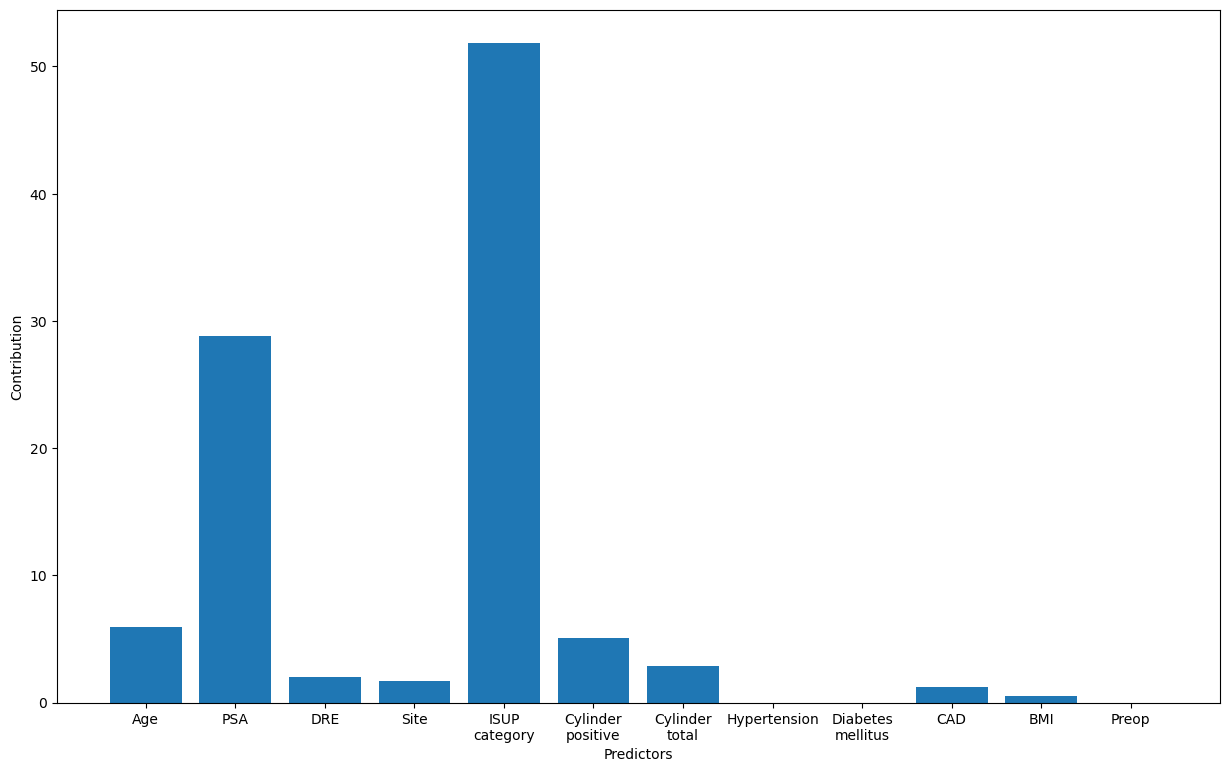

In [55]:
plt.figure(figsize=(15,9))
plt.bar([x for x in range(len(dt_clf.feature_importances_))], dt_clf.feature_importances_*100, tick_label=feature_labels)
plt.xlabel("Predictors")
plt.ylabel("Contribution")
plt.show()

In [57]:
pd.DataFrame(rnd_clf.feature_importances_.reshape(1, len(rnd_clf.feature_importances_))*100, columns=feature_labels)

,Age,PSA,DRE,Site,ISUP\ncategory,Cylinder\npositive,Cylinder\ntotal,Hypertension,Diabetes\nmellitus,CAD,BMI,Preop
0,13.959254,24.650472,4.167505,3.547087,24.60172,11.644014,9.028029,2.854429,1.316657,1.00197,0.510168,2.718694


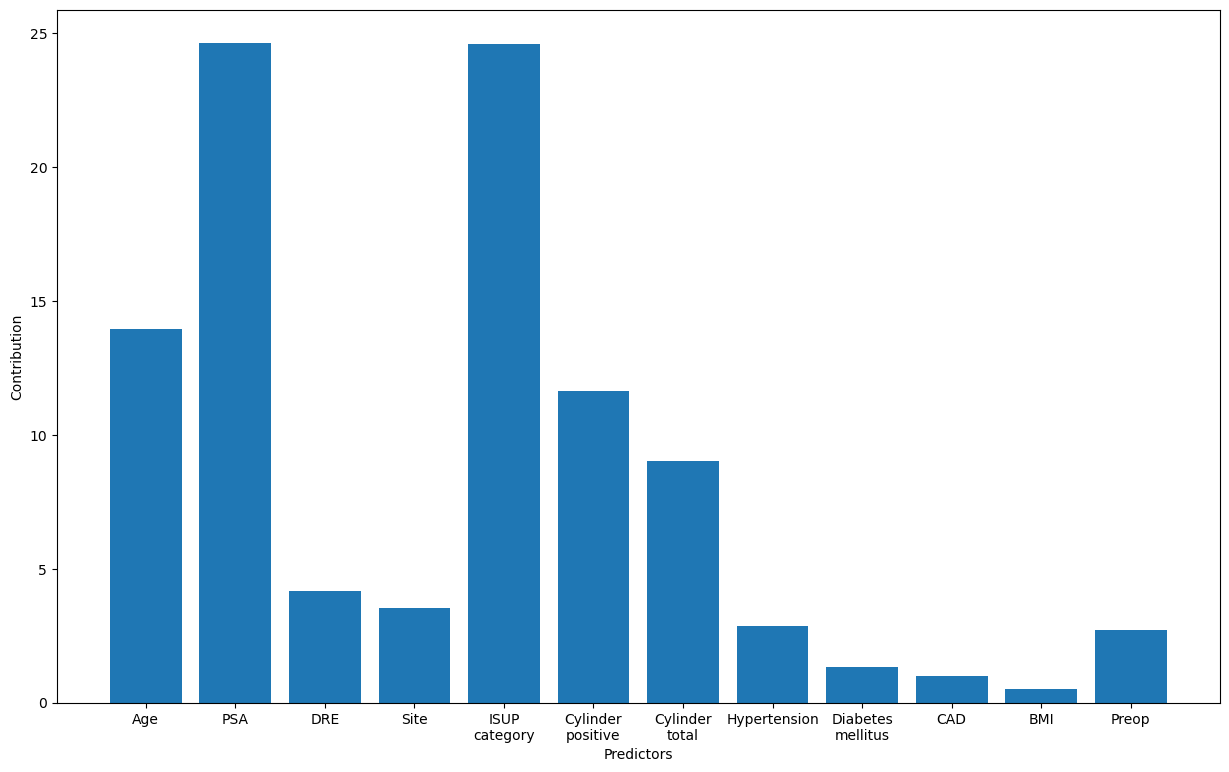

In [56]:
importances = rnd_clf.feature_importances_
plt.figure(figsize=(15,9))
plt.bar([x for x in range(len(rnd_clf.feature_importances_))], rnd_clf.feature_importances_*100, tick_label=feature_labels)
plt.xlabel("Predictors")
plt.ylabel("Contribution")
plt.show()

In [48]:
# Train DecisionTree model for demo
dt_clf_demo = DecisionTreeClassifier(max_depth=3, criterion="entropy", random_state=random_state)
dt_clf_demo.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=6)

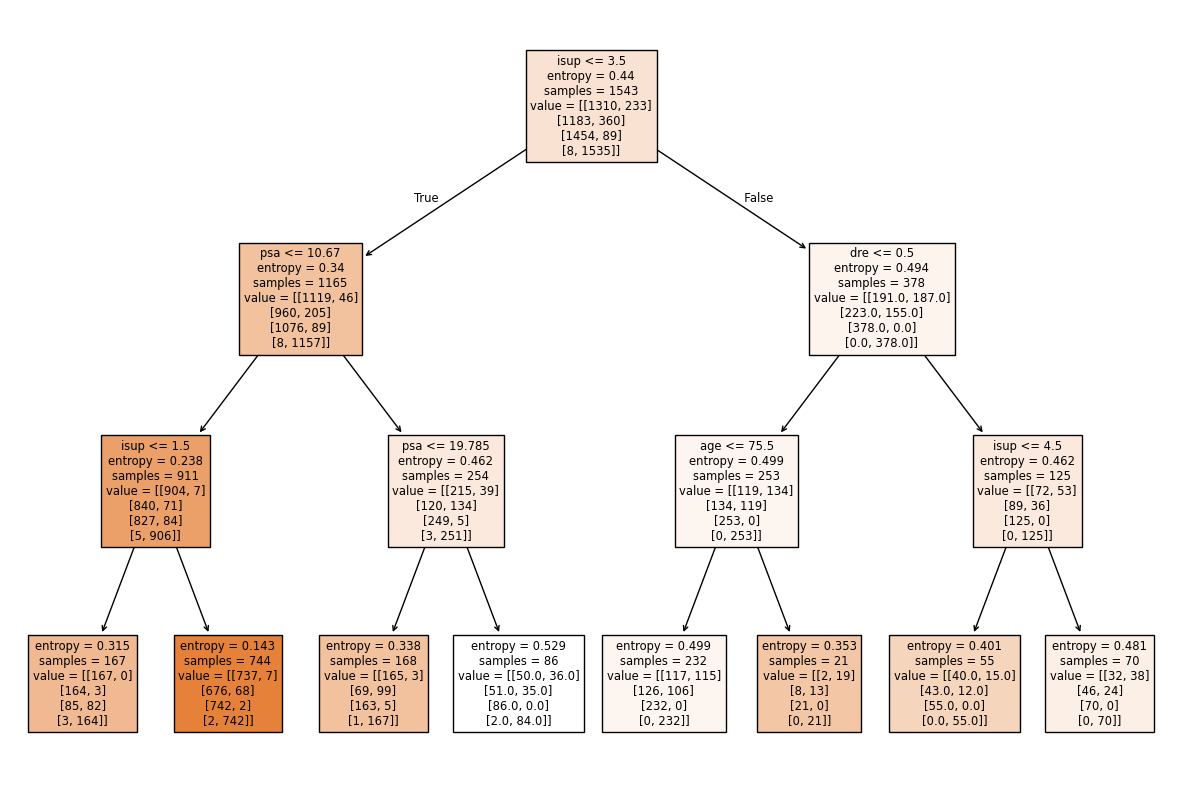

In [49]:
from sklearn import tree

plt.figure(figsize=(15,10))
_ = tree.plot_tree(dt_clf_demo, feature_names=feature_cols, filled=True)